# Hands On 2 - Machine learning on clustering

The purpose of this laboratory is to make you practice with the data preparation process. More specifically, you will tackle the task with tabular and textual input data, learning how to handle anomalies in the data, missing values and more.


### 1.0 Plotting

In order to complete some of the optional exercises you will need the `matplotlib` plotting library. You can read more about it on its [official documentation](https://matplotlib.org/). You can check if it is already installed by running `import matplotlib` in Jupyter.
Among its numerous functionalities, you will use the histogram plotting function in this laboratories. An histogram is a simple representation of the distribution of numerical data. It presents the binned range of values on x-axis (i.e. a series of intervals in which data is divided) and the frequency of each bin on the y-axis. 
Here it is a short python script on how to use matplotlib to plot the histogram of values contained in a list.

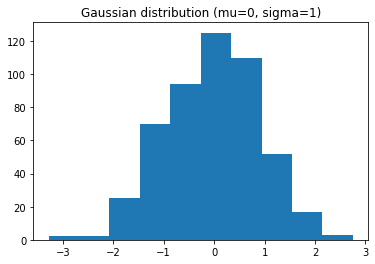

In [1]:
from random import gauss
import matplotlib.pyplot as plt
%matplotlib inline

l = [gauss(0, 1) for _ in range(500)]

plt.hist(l)
plt.title('Gaussian distribution (mu=0, sigma=1)')
plt.show()


## 1.1 Global Land Temperature

The Global Land Temperature (GLT) dataset is a large collection of measurements actively maintained by Berkeley Earth. It contains the raw source data measured with stations all around the globe, plus an intermediate format and several formatted output files. Data span from ∼1750 up to recent days with monthly and daily availability. Measurements are provided by hemispheres, states, countries, cities and more. You can read more about the dataset at the [Berkeley Earth website](https://berkeleyearth.org/data/). 

For the purpose of this laboratory you will work on a modified, smaller but dirtier, version of the original GLT dataset, to stress the importance of data preprocessing. More specifically, this didactic version contains the formatted output files of the major cities of the globe with monthly granularity. For the sake of simplicity, the analysis will range between almost two centuries (i.e. between the years 1817 and 2012).

The dataset is composed of **∼200k rows** corresponding to the measurements taken the first day of the month in a given city. Each measurement is then described by 7 values:
- Date, when the measurement was taken
- AverageTemperature
- AverageTemperatureUncertainty
- City, from which the measurement was taken
- Country
- Latitude
- Longitude
The dataset is available in CSV format. You can find it at the following URL`

https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/GLT_filtered.csv

## Data Preprocessing

The main goal of this exercise is to learn how to clean a real-world dataset searching for anomalies, such as missing values or outliers, in its data.

**Prerequisites.** There are many ways to handle missing values. One can decide to delete a row of the dataset based on whether a missing value is present or not. This strategy can be adopted when the dataset is large and the information loss does not affect the overall distribution. Another common solution is to fill every missing value. If data has not a specific order, they can be replaced with the mean (or the median) of the involved attribute. Temporal data, instead, allow to replace missing values with values of adjacent rows, e.g. by averaging them. Clearly, this technique is possible if the data type allows to compute the mean.

1. Load the Global Land Temperature dataset as a list of lists. Before starting, take a moment to better inspect the attributes you are going to work on. How many of them are nominal, how many continuous or discrete?

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/dbdmg/data-science-lab/master/datasets/GLT_filtered.csv')

In [3]:
df[['City', 'Country', 'Latitude', 'Longitude']].describe()

,City,Country,Latitude,Longitude
count,219575,219575,219575,219575
unique,100,49,49,93
top,Delhi,China,31.35N,31.38E
freq,2352,35300,13493,6576


In [4]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,191994.000000,191994.000000
mean,19.074293,1.148474
std,11.705712,3.374958
min,-26.772000,0.049000
25%,13.399000,0.329000
50%,20.857000,0.549000
75%,26.112000,1.151000
max,88.007000,41.588600


In [5]:
df.head()

,Date,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,NaN,NaN,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


2. Analyze the attribute **AverageTemperature**, which contains missing values. Fill any gap with the arithmetic mean among the closest antecedent and the closest successive measurements in time, **taken in the same city**. Assume the following rules for edge cases:
    
    **(a)** it can happen that a missing value does not have a preceding (or successive) measurement. This happens when the missing value is the first (or last) value of the dataset. If this is the case, consider the missing value to be preceded (or followed) by a 0, then compute the mean accordingly.

    ```
    original_list = [ '', 5, 6, '' ]
    step_1 = [ 2.5, 5, 6, '' ] # (0 + 5) / 2
    step_2 = [ 2.5, 5, 6, 3 ] # (6 + 0) / 2`
    ```

    **(b)** if there are consecutive missing values, just compute them in temporal order and use the newly inserted values to evaluate the following ones. Here it is an example with a simple list where both (a) and (b) rules have been applied:`
    
    ```
    original_list = [ '', '', 24, 28.9 ]
    step_1 = [ 12, '', 24, 28.9 ] # (0 + 24) / 2
    step_2 = [ 12, 18, 24, 28.9 ] # (12 + 24) / 2
    ```
> **Note:** Missed values in pandas Series are `NaN`

In [6]:
df[['AverageTemperature', 'AverageTemperatureUncertainty']].isna().sum()

AverageTemperature               27581
AverageTemperatureUncertainty    27581
dtype: int64

In [7]:
def fill_gaps(data, cities):
    right_i = 0
    right_v = 0
    filled_data = data.copy()
    
    for i, value in enumerate(filled_data):
        if i == 0 or cities[i] != cities[i-1]:
            left_v = 0
        else:
            left_v = filled_data[i-1]

        # reuse the right_v value, useful when there are multiple consecutive missing values
        if i < right_i:
            filled_data[i] = (left_v + right_v) / 2
            continue

        if np.isnan(value):
            for j in range(i+1, len(filled_data)):
                if cities[j] != cities[i]: # this check must come before
                    right_v = 0
                    break
                elif not np.isnan(filled_data[j]):
                    right_v = filled_data[j]
                    break

            if i == len(filled_data)-1: # edge case: the last value of the last city is empty
                right_v = 0

            right_i = j 
            filled_data[i] = (left_v + right_v) / 2

        else:
            pass # data[i] is fine
    return filled_data

In [9]:
test_df = pd.DataFrame({
    'AverageTemperature': [np.nan, 12, np.nan, np.nan, np.nan, 15, np.nan],
    'City': ['Rome', 'Rome', 'Rome', 'Turin', 'Turin', 'Turin', 'Turin']})

print('Original list:', test_df.AverageTemperature)
test_df.AverageTemperature = fill_gaps(test_df.AverageTemperature, test_df.City)
print('Filled list:', test_df.AverageTemperature)

Original list: 0     NaN
1    12.0
2     NaN
3     NaN
4     NaN
5    15.0
6     NaN
Name: AverageTemperature, dtype: float64
Filled list: 0     6.00
1    12.00
2     6.00
3     7.50
4    11.25
5    15.00
6     7.50
Name: AverageTemperature, dtype: float64


In [10]:
# Check the result:
df.AverageTemperature = fill_gaps(df.AverageTemperature, df.City)
print(f"Null values: {df.AverageTemperature.isna().sum()}")

Null values: 0


3. Define a function that, given the name of a city and an integer N > 0, prints:
    (a) the top N hottest measurements;
    (b) the top N coldest measurements.

In [11]:
def print_hottest_coolest(city, N, data):
    srtd = data[data.City==city].AverageTemperature.sort_values(ascending=False)
    print(f'The top {N} hottest measurements taken in {city} are:\n', srtd.iloc[:N])
    print(f'The top {N} coolest measurements taken in {city} are:\n', srtd.iloc[-N:])

In [12]:
print_hottest_coolest('Rome', 3, df)

The top 3 hottest measurements taken in Rome are:
 173742    25.951
173741    24.998
173634    24.873
Name: AverageTemperature, dtype: float64
The top 3 coolest measurements taken in Rome are:
 172067   -1.019
173172   -1.304
173003   -1.441
Name: AverageTemperature, dtype: float64


4. Let’s search for other anomalies in data distribution with the help of matplotlib. Plot the distribution of the average land temperatures for Rome and Bangkok using the aforementioned histogram
plotting function.

> **Info:** calling the plt.hist() method twice will draw the second histogram onto the canvas generated by the first call.


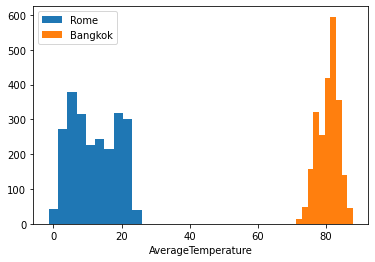

In [13]:
import matplotlib.pyplot as plt

for city in ['Rome', 'Bangkok']:
    plt.hist(df[df.City==city].AverageTemperature, label=city)
plt.legend()
_ = plt.xlabel('AverageTemperature')

As you can see, Rome and Bangkok have very different temperature distributions, but this seems
plausible. What it looks strange is the large difference in their temperatures’ magnitude. Is it possible that all sensors from Bangkok stations, along the entire time-span, were faulty? Could they were configured to use another representation of the temperature measurement? Can you figure out a data cleaning step to solve it?

_Before continuing, try to answer to these questions._

5. One might think that Bangkok sensor provide temperature samples in degrees Fahrenheit while
the ones located in Rome use the Celsius notation, which is the common representation in the whole dataset. Write a function to transform Fahrenheit measurements back to Celsius, apply it to your data and plot the two distribution again.

> **Info:** remember that the mapping function from Celsius to Fahrenheit is the following
> $$T_F = 1.8 · T_C + 32$$


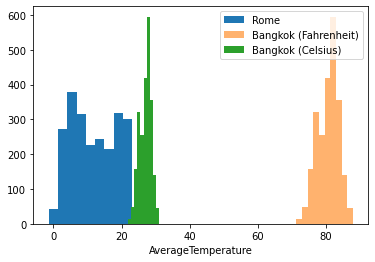

In [14]:
def fah2cel(deg_fah):
    return (deg_fah - 32) / 1.8

bang_celsius = df[df.City=='Bangkok'].AverageTemperature.apply(fah2cel)
plt.hist(df[df.City=='Rome'].AverageTemperature, label='Rome')
plt.hist(df[df.City=='Bangkok'].AverageTemperature, label='Bangkok (Fahrenheit)', alpha=0.6)
plt.hist(bang_celsius, label='Bangkok (Celsius)')
plt.legend()
_ = plt.xlabel('AverageTemperature')

In [15]:
print(f"Rome average temperature: {df[df.City=='Rome'].AverageTemperature.mean():.2f}, Standard deviation: {df[df.City=='Rome'].AverageTemperature.std():2f}\n")
print(f"Bangkok average temperature: {df[df.City=='Bangkok'].AverageTemperature.mean():.2f}, Standard deviation: {df[df.City=='Bangkok'].AverageTemperature.std():.2f}")

Rome average temperature: 12.01, Standard deviation: 6.694663

Bangkok average temperature: 80.73, Standard deviation: 3.05
